# <center> **Time-Series Forecasting of Bike Rental Demand using XGBoost**

## **Objective:** 
To develop a robust predictive model to forecast bike rental demand by leveraging historical data. The model addresses missing data, employ sophisticated feature engineering techniques, and rigorously evaluate performance. The goal is to generate actionable insights for optimizing bike distribution and improving service levels across the bike-sharing network.

---

## **Index:**
    1. Importing Libraries
    2. Loading Data
    3. Exploring Data
        a. Checking Null Values
        b. Checking Regularity of Time Series Data
        c. Plotting Trends
    4. Feature Engineering
    5. Training
        a. Time Series Cross-Validation
        b. Fitting XGBRegressor Model
        c. Hyperparameter Tuning Using GridSearchCV
        d. Training on Best Features and Best Hyperparamters
        e. Visualising True vs Predicted Values
    6. Forecasting Test Data

---

## **1. Importing Libraries**

In [ ]:
!pip install numpy pandas matplotlib seaborn xgboost scikit-learn

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

---

## **2 Loading Data**

In [33]:
df = pd.read_csv('train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [34]:
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

In [35]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


---

## **3. Exploring Data**

### **a. Checking Null Values**

In [36]:
print(df.isnull().sum())

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


### **b. Checking Regularity of Time Series Data**

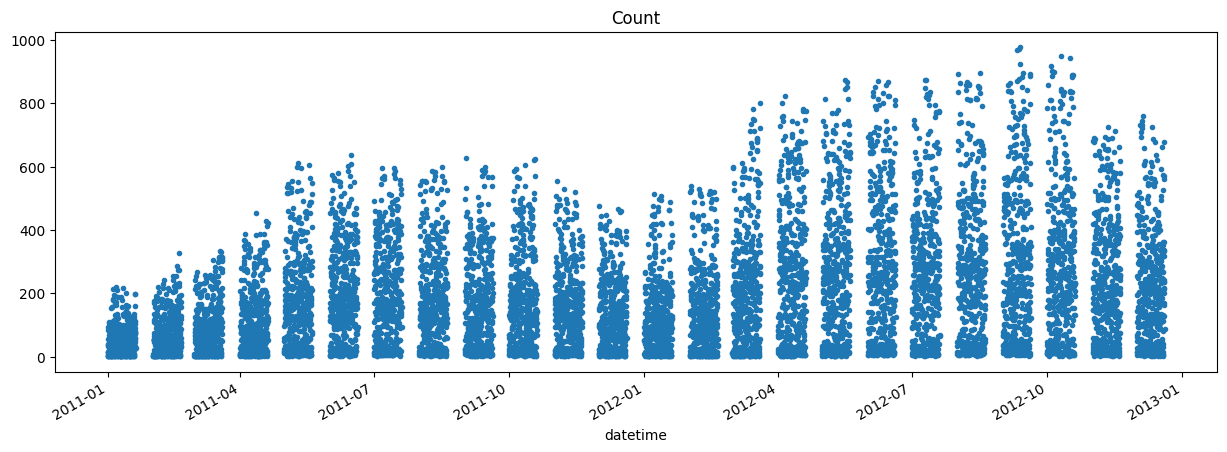

In [37]:
df['count'].plot(style='.', figsize=(15, 5), title='Count')
plt.show()

In [38]:
time_diffs = df.index.to_series().diff()
print(time_diffs.unique())

<TimedeltaArray>
[               NaT,  '0 days 01:00:00',  '0 days 02:00:00',
  '0 days 03:00:00',  '0 days 13:00:00', '12 days 01:00:00',
  '9 days 01:00:00', '11 days 01:00:00', '10 days 01:00:00']
Length: 9, dtype: timedelta64[ns]


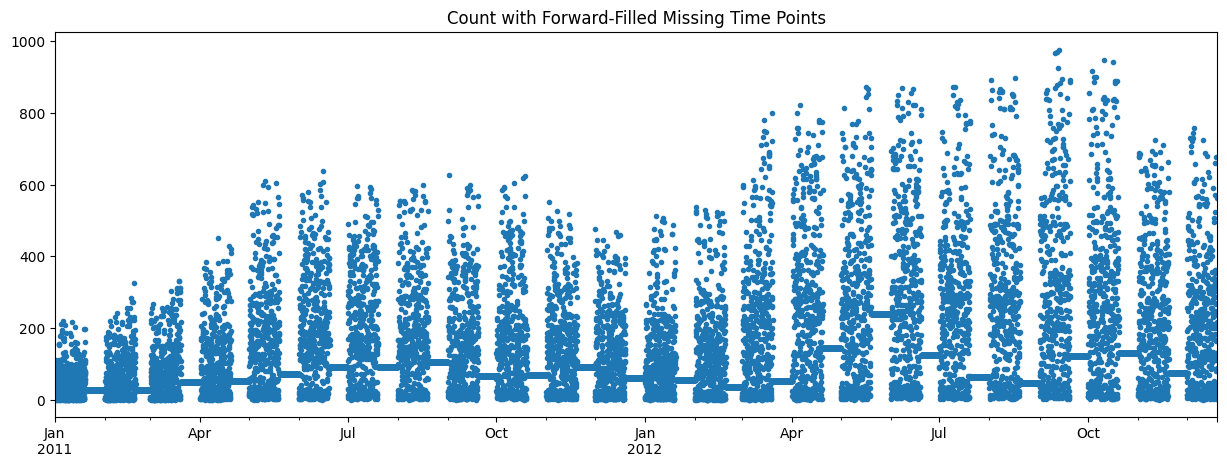

In [39]:
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

df_reindexed = df.reindex(full_index)

df_reindexed['count'] = df_reindexed['count'].fillna(method='ffill')

df_reindexed['count'].plot(style='.', figsize=(15, 5), title='Count with Forward-Filled Missing Time Points')
plt.show()

In [40]:
time_diffs = df_reindexed.index.to_series().diff()
print(time_diffs.unique())

<TimedeltaArray>
[NaT, '0 days 01:00:00']
Length: 2, dtype: timedelta64[ns]


In [41]:
df = df_reindexed

In [42]:
print(df.isnull().sum())


season        6370
holiday       6370
workingday    6370
weather       6370
temp          6370
atemp         6370
humidity      6370
windspeed     6370
casual        6370
registered    6370
count            0
dtype: int64


In [43]:
df = df.fillna(method='ffill')
print(df.isnull().sum())

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


### **c. Plotting Trends**

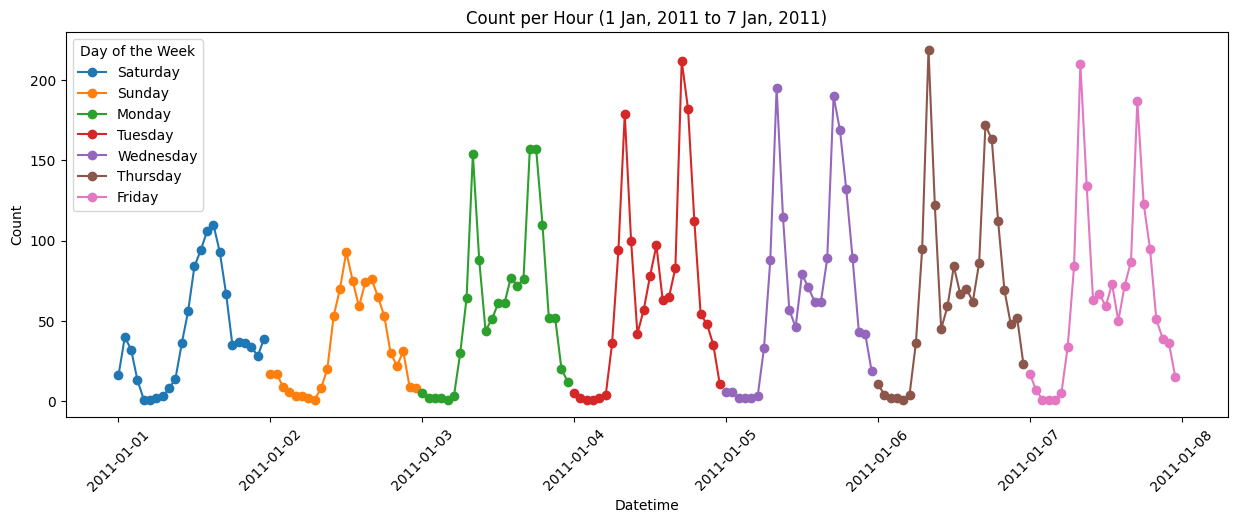

In [44]:
df_hourly = df.resample('H').sum()
df_week = df_hourly.loc['2011-01-01':'2011-01-07'].copy()
df_week['day_of_week'] = df_week.index.day_name()
days_of_week = df_week['day_of_week'].unique()
plt.figure(figsize=(15, 5))

for day in days_of_week:
    df_day = df_week[df_week['day_of_week'] == day]
    plt.plot(df_day.index, df_day['count'], '-o', label=day)

plt.title('Count per Hour (1 Jan, 2011 to 7 Jan, 2011)')
plt.ylabel('Count')
plt.xlabel('Datetime')
plt.legend(title='Day of the Week')
plt.xticks(rotation=45)
plt.show()

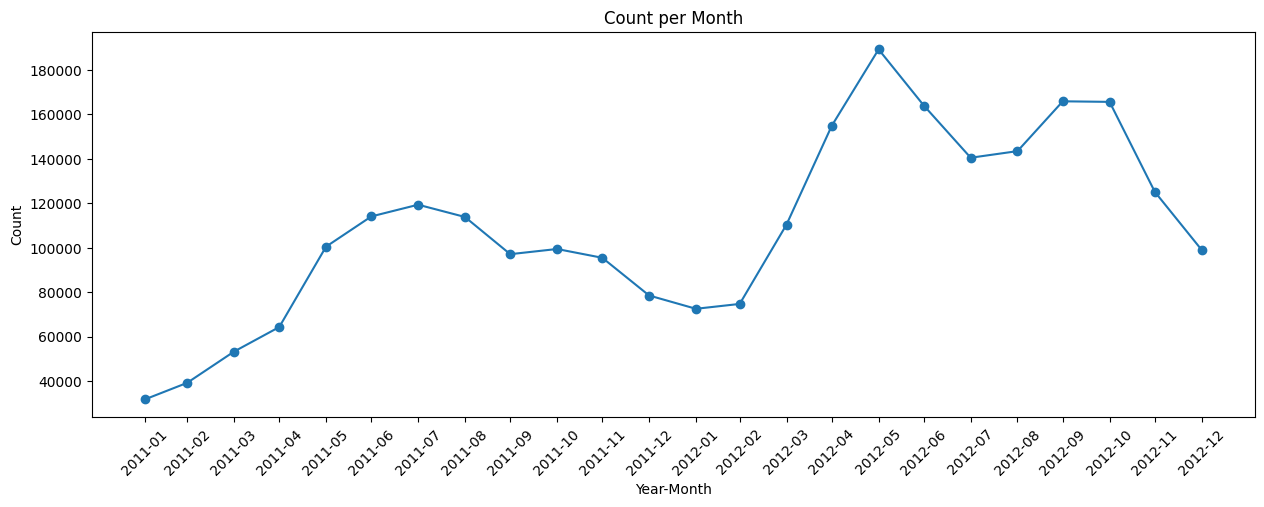

In [45]:
df_monthly = df.resample('M').sum()
df_monthly['year_month'] = df_monthly.index.strftime('%Y-%m')

plt.figure(figsize=(15, 5))
plt.plot(df_monthly.index, df_monthly['count'], '-o', label='Total Count')
plt.title('Count per Month')
plt.ylabel('Count')
plt.xlabel('Year-Month')
plt.xticks(df_monthly.index, df_monthly['year_month'], rotation=45)
plt.show()

---

## **4. Feature Engineering**

In [46]:
def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,3.0,13.0,16.0,0,5,1,1,2011,1,1,52
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,8.0,32.0,40.0,1,5,1,1,2011,1,1,52
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,5.0,27.0,32.0,2,5,1,1,2011,1,1,52
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,3.0,10.0,13.0,3,5,1,1,2011,1,1,52
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,0.0,1.0,1.0,4,5,1,1,2011,1,1,52


In [47]:
print(df.columns)

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear'],
      dtype='object')


In [48]:
features = ['season', 'holiday', 'workingday', 'weather', 
            'temp', 'atemp', 'humidity', 'windspeed', 
            'hour', 'dayofweek', 'quarter', 'month', 
            'year', 'dayofyear', 'dayofmonth', 'weekofyear']

target = ['count']

---

## **5. Training**

### **a. Time Series Cross-Validation**

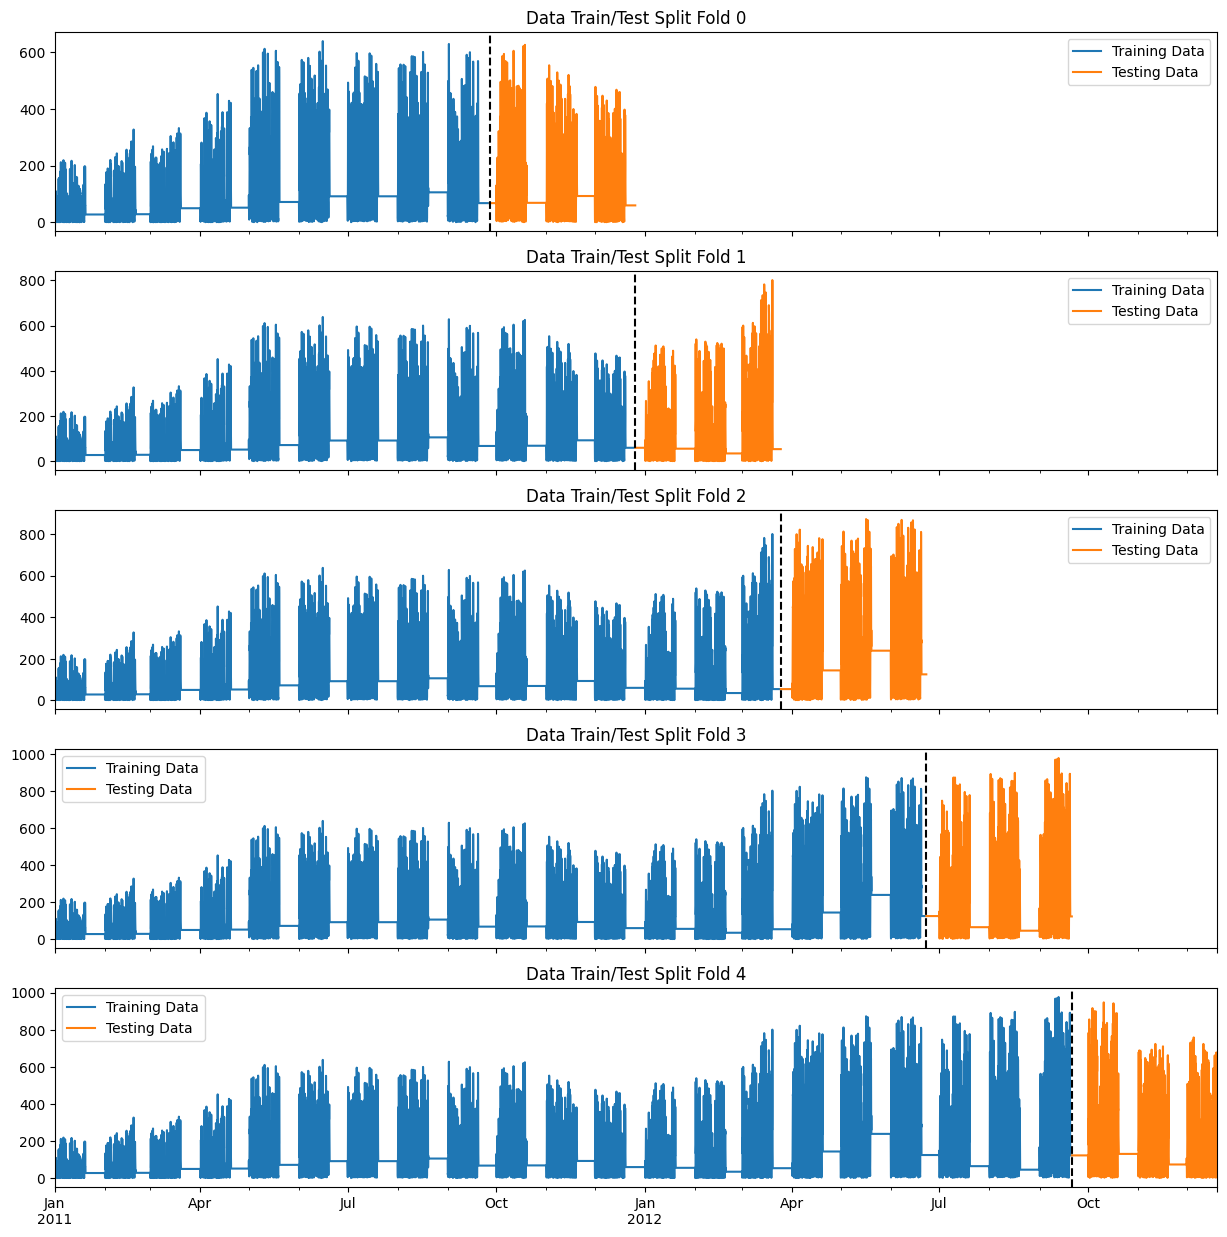

In [49]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*90, gap=1)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train['count'].plot(ax=axs[fold], label='Training Data', title=f'Data Train/Test Split Fold {fold}')
    test['count'].plot(ax=axs[fold], label='Testing Data')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()
    fold += 1

plt.show()

### **b. Fitting XGBRegressor Model**

In [50]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*90, gap=1)

fold = 0
mse_scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train, y_train = train[features], train['count']
    X_test, y_test = test[features], test['count']
    
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    print(f'Fold {fold} - Mean Squared Error: {mse}')
    
    fold += 1

print(f'\nAverage MSE: {np.mean(mse_scores)}')

Fold 0 - Mean Squared Error: 1861.8650634717367
Fold 1 - Mean Squared Error: 8255.74508438043
Fold 2 - Mean Squared Error: 5009.713696829858
Fold 3 - Mean Squared Error: 4817.354816918756
Fold 4 - Mean Squared Error: 2795.985791981781

Average MSE: 4548.1328907165125


### **c. Hyperparameter Tuning Using GridSearchCV**

In [21]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*90, gap=1)

param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 500, 1000, 1500],
    'max_depth': [3, 6, 9, 12]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tss, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}
Best Score: -4956.395543447094


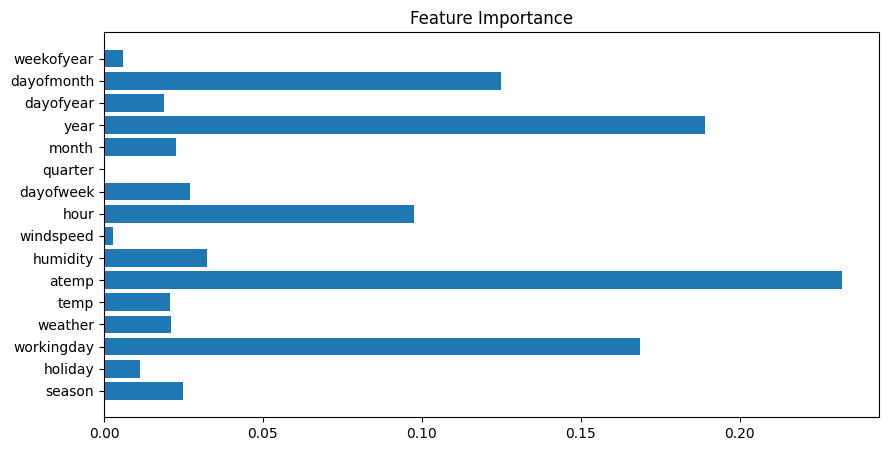

In [22]:
feature_importances = model.feature_importances_

plt.figure(figsize=(10, 5))
plt.barh(features, feature_importances)
plt.title('Feature Importance')
plt.show()

## **d. Training on Best Features and Best Hyperparamters**

In [51]:
best_features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
            'humidity', 'hour', 'dayofweek', 'month', 'year',
            'dayofyear', 'dayofmonth']

In [52]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*30, gap=1)

fold = 0
mse_scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train, y_train = train[best_features], train['count']
    X_test, y_test = test[best_features], test['count']

    model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    print(f'Fold {fold} - Mean Squared Error: {mse}')
    fold += 1

print(f'\nAverage MSE: {np.mean(mse_scores)}')

Fold 0 - Mean Squared Error: 3171.4401951027944
Fold 1 - Mean Squared Error: 3325.5816904495973
Fold 2 - Mean Squared Error: 3415.1221708763883
Fold 3 - Mean Squared Error: 2680.4619571516473
Fold 4 - Mean Squared Error: 1862.354156840859

Average MSE: 2890.9920340842573


#
#### **Average MSE Before and After Hyperparameter Tuning:**
    Before: 4548.1328907165125
    After:  2890.9920340842573
#

### **e. Visualising True vs Predicted Values**

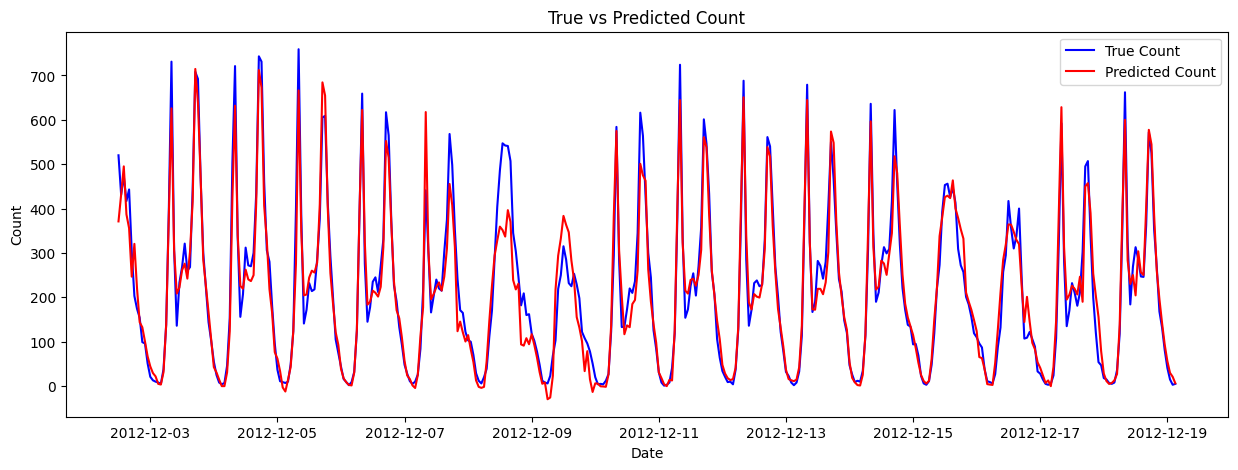

In [55]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index[300:700], y_test[300:700], label='True Count', color='blue')
plt.plot(y_test.index[300:700], y_pred[300:700], label='Predicted Count', color='red', linestyle='-')
plt.title('True vs Predicted Count')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

---

## **6. Forecasting Test Data**

In [26]:
df_test = pd.read_csv('test.csv')
df_test = df_test.set_index('datetime')
df_test.index = pd.to_datetime(df_test.index)

df_test = create_features(df_test)
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
datetime,,,,,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,1,2011,20,20,3
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,1,2011,20,20,3
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,1,2011,20,20,3
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,1,2011,20,20,3
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,1,2011,20,20,3


In [27]:
X_test = df_test[best_features]

In [28]:
X_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,hour,dayofweek,month,year,dayofyear,dayofmonth
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,0,3,1,2011,20,20
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,1,3,1,2011,20,20
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,2,3,1,2011,20,20
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,3,3,1,2011,20,20
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,4,3,1,2011,20,20


In [29]:
y_pred_test = model.predict(X_test)
df_test['predicted_count'] = y_pred_test
df_test[['predicted_count']].to_csv('test_predictions.csv')

In [30]:
df_pred = pd.read_csv('test_predictions.csv')
df_pred = df_pred.set_index('datetime')
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.head()

,predicted_count
datetime,
2011-01-20 00:00:00,38.575592
2011-01-20 01:00:00,38.472816
2011-01-20 02:00:00,38.827187
2011-01-20 03:00:00,38.224213
2011-01-20 04:00:00,38.224213


---